<!-- dom:TITLE: Data Analysis and Machine Learning: Preprocessing and Dimensionality Reduction -->
# Data Analysis and Machine Learning: Preprocessing and Dimensionality Reduction
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Oct 17, 2019**

Copyright 1999-2019, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license




## Reducing the number of degrees of freedom, overarching view

Many Machine Learning problems involve thousands or even millions of features for each training
instance. Not only does this make training extremely slow, it can also make it much harder to find a good
solution, as we will see. This problem is often referred to as the curse of dimensionality.
Fortunately, in real-world problems, it is often possible to reduce the number of features considerably,
turning an intractable problem into a tractable one.

Here we will discuss some of the most popular dimensionality
reduction techniques: the principal component analysis PCA, Kernel PCA, and Locally Linear Embedding (LLE).
Furthermore, we will start by looking at some simple preprocessing of the data which allow us to rescale the data.




## Preprocessing our data

Before we proceed however, we will discuss how to preprocess our
data. Till now and in connection with our previous examples we have not met so many cases
where we are too sensitive to the scaling of our data. Normally the
data may need a rescaling and/or may be sensitive to extreme
values. Scaling the data renders our inputs much more suitable for the
algorithms we want to employ.

**Scikit-Learn** has several functions which allow us to rescale the
data, normally resulting in much better results in terms of various
accuracy scores.  The **StandardScaler** function in **Scikit-Learn**
ensures that for each feature/predictor we study the mean value is
zero and the variance is one (every column in the design/feature
matrix).  This scaling has the drawback that it does not ensure that
we have a particular maximum or minimum in our data set. Another
function included in **Scikit-Learn** is the **MinMaxScaler** which
ensures that all features are exactly between $0$ and $1$. The

## More preprocessing


The **Normalizer** scales each data
point such that the feature vector has a euclidean length of one. In other words, it
projects a data point on the circle (or sphere in the case of higher dimensions) with a
radius of 1. This means every data point is scaled by a different number (by the
inverse of it’s length).
This normalization is often used when only the direction (or angle) of the data matters,
not the length of the feature vector.

The **RobustScaler** works similarly to the StandardScaler in that it
ensures statistical properties for each feature that guarantee that
they are on the same scale. However, the RobustScaler uses the median
and quartiles, instead of mean and variance. This makes the
RobustScaler ignore data points that are very different from the rest
(like measurement errors). These odd data points are also called
outliers, and might often lead to trouble for other scaling
techniques.



## Simple preprocessing examples, Franke function and regression

In [1]:
%matplotlib inline

# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.svm import SVR

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')


def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4


def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X


# Making meshgrid of datapoints and compute Franke's function
n = 5
N = 1000
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
z = FrankeFunction(x, y)
X = create_X(x, y, n=n)    
# split in training and test data
X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.2)


svm = SVR(gamma='auto',C=10.0)
svm.fit(X_train, y_train)

# The mean squared error and R2 score
print("MSE before scaling: {:.2f}".format(mean_squared_error(svm.predict(X_test), y_test)))
print("R2 score before scaling {:.2f}".format(svm.score(X_test,y_test)))

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature min values before scaling:\n {}".format(X_train.min(axis=0)))
print("Feature max values before scaling:\n {}".format(X_train.max(axis=0)))

print("Feature min values after scaling:\n {}".format(X_train_scaled.min(axis=0)))
print("Feature max values after scaling:\n {}".format(X_train_scaled.max(axis=0)))

svm = SVR(gamma='auto',C=10.0)
svm.fit(X_train_scaled, y_train)

print("MSE after  scaling: {:.2f}".format(mean_squared_error(svm.predict(X_test_scaled), y_test)))
print("R2 score for  scaled data: {:.2f}".format(svm.score(X_test_scaled,y_test)))

MSE before scaling: 0.01
R2 score before scaling 0.93
Feature min values before scaling:
 [1.00000000e+00 1.56868531e-04 4.25016115e-04 2.46077359e-08
 6.66716535e-08 1.80638698e-07 3.86017938e-12 1.04586843e-11
 2.83365271e-11 7.67743576e-11 6.05540668e-16 1.64063844e-15
 4.44510938e-15 1.20434807e-14 3.26303392e-14 9.49902749e-20
 2.57364542e-19 6.97297777e-19 1.88924312e-18 5.11867337e-18
 1.38684200e-17]
Feature max values before scaling:
 [1.         0.99980229 0.9996158  0.99960462 0.99941816 0.99923174
 0.99940699 0.99922057 0.99903418 0.99884783 0.99920939 0.99902301
 0.99883666 0.99865035 0.99846407 0.99901184 0.99882549 0.99863918
 0.99845291 0.99826666 0.99808046]
Feature min values after scaling:
 [ 0.         -1.78024859 -1.70920112 -1.1515339  -1.1300959  -1.11033121
 -0.90340545 -0.8959348  -0.88900131 -0.88255214 -0.76338933 -0.76113708
 -0.75906691 -0.7571601  -0.75539963 -0.67113296 -0.67101229 -0.6709573
 -0.67096075 -0.67101596 -0.67111677]
Feature max values after 

## Simple preprocessing examples, breast cancer data and classification, Support Vector Machines

We show here how we can use a simple regression case on the breast
cancer data using support vector machines (SVM) as algorithm for
classification.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)

svm = SVC(C=100)
svm.fit(X_train, y_train)
print("Test set accuracy: {:.2f}".format(svm.score(X_test,y_test)))

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature min values before scaling:\n {}".format(X_train.min(axis=0)))
print("Feature max values before scaling:\n {}".format(X_train.max(axis=0)))

print("Feature min values before scaling:\n {}".format(X_train_scaled.min(axis=0)))
print("Feature max values before scaling:\n {}".format(X_train_scaled.max(axis=0)))


svm.fit(X_train_scaled, y_train)
print("Test set accuracy scaled data with Min-Max scaling: {:.2f}".format(svm.score(X_test_scaled,y_test)))

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm.fit(X_train_scaled, y_train)
print("Test set accuracy scaled data with Standar Scaler: {:.2f}".format(svm.score(X_test_scaled,y_test)))

(426, 30)
(143, 30)
Test set accuracy: 0.63
Feature min values before scaling:
 [6.981e+00 9.710e+00 4.379e+01 1.435e+02 5.263e-02 1.938e-02 0.000e+00
 0.000e+00 1.060e-01 4.996e-02 1.115e-01 3.628e-01 7.570e-01 7.228e+00
 1.713e-03 2.252e-03 0.000e+00 0.000e+00 7.882e-03 8.948e-04 7.930e+00
 1.202e+01 5.041e+01 1.852e+02 7.117e-02 2.729e-02 0.000e+00 0.000e+00
 1.565e-01 5.504e-02]
Feature max values before scaling:
 [2.811e+01 3.381e+01 1.885e+02 2.501e+03 1.447e-01 3.114e-01 4.268e-01
 2.012e-01 3.040e-01 9.744e-02 2.873e+00 4.885e+00 2.198e+01 5.422e+02
 2.333e-02 1.064e-01 3.960e-01 5.279e-02 6.146e-02 2.984e-02 3.604e+01
 4.954e+01 2.512e+02 4.254e+03 2.226e-01 1.058e+00 1.252e+00 2.903e-01
 6.638e-01 2.075e-01]
Feature min values before scaling:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Feature max values before scaling:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
Test set accur

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## More on Cancer Data, now with Logistic Regression

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()

# Set up training data
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Test set accuracy: {:.2f}".format(logreg.score(X_test,y_test)))

# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))

## Why should we think of reducing the dimensionality

In addition to the plot of the features, we study now also the covariance (or rather the correlation matrix).
We use also **Pandas** to compute the correlation matrix.

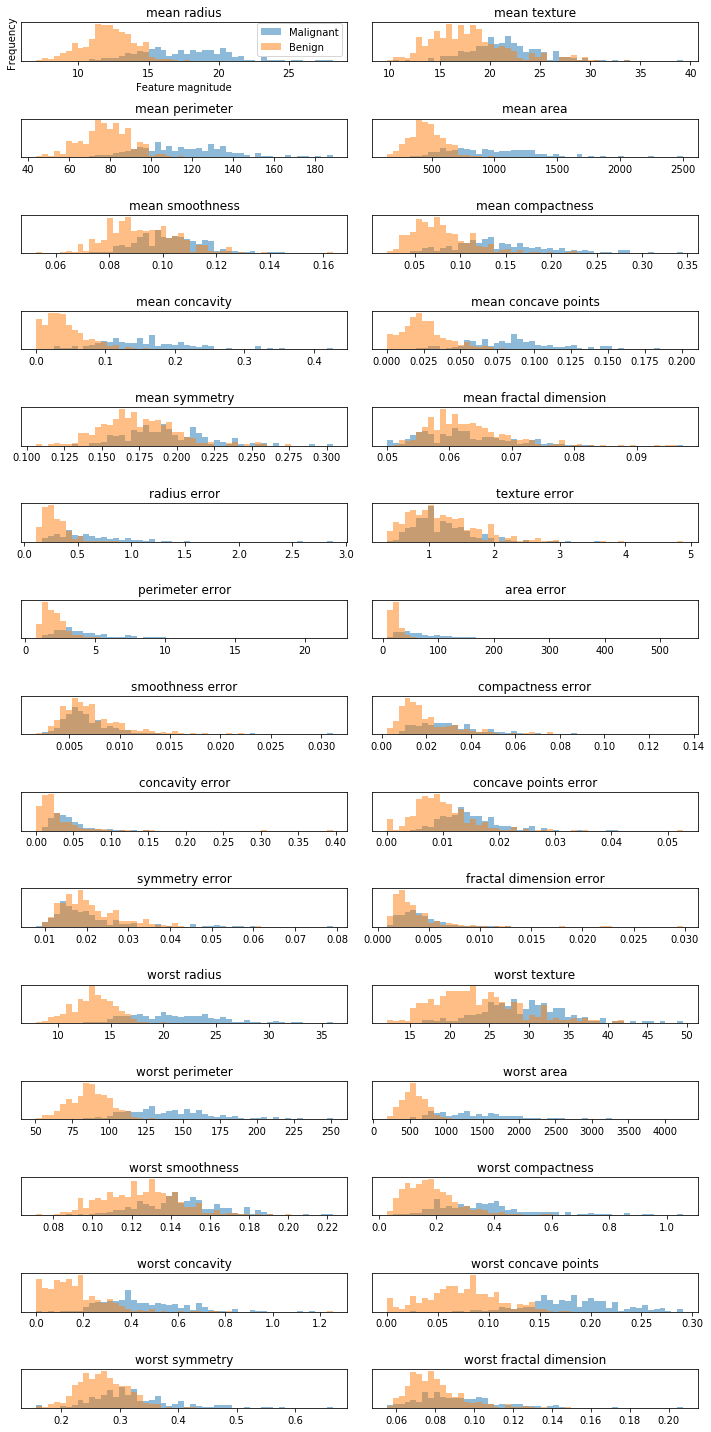

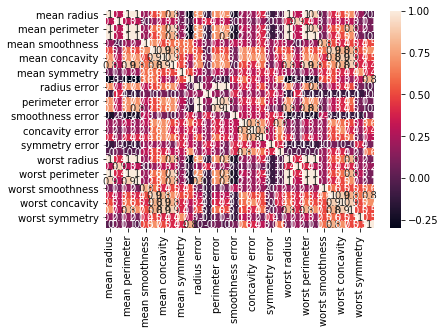

[ 1.33026664e+01  5.69238112e+00  2.83259341e+00  1.99126621e+00
  1.69095941e+00  1.19614372e+00  7.13037918e-01  5.77804918e-01
  5.14549644e-01  4.30579019e-01  3.58977964e-01 -1.91269450e-01
  2.86195387e-01 -1.59310961e-01 -1.38483045e-01  2.44786221e-01
 -8.79318674e-02  1.91811329e-01  1.70896266e-01 -7.17683028e-02
  1.39860289e-01  1.18721828e-01 -4.83194721e-02  8.92983892e-02
  6.81402316e-02  6.01968016e-02  3.31819744e-02  1.56432255e-02
 -1.61028757e-02 -6.50565973e-03]
(426, 30)
(143, 30)
Test set accuracy from Logistic Regression: 0.96
Test set accuracy scaled data: 0.96


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()
import pandas as pd
# Making a data frame
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

fig, axes = plt.subplots(15,2,figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins =50)
    ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
    ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["Malignant", "Benign"], loc ="best")
fig.tight_layout()
plt.show()

import seaborn as sns
correlation_matrix = cancerpd.corr().round(1)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

#print eigvalues of correlation matrix
EigValues, EigVectors = np.linalg.eig(correlation_matrix)
print(EigValues)

#split into train and test and then scale thereafter
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Test set accuracy from Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg.fit(X_train_scaled, y_train)
print("Test set accuracy scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))

## Getting started with PCA

This material is being finalized, not yet ready.

In [5]:
# Now add PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X_train_scaled)

X_pca = pca.transform(X_train_scaled)

## Principal Component Analysis
Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm.
First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

The following Python code uses NumPy’s **svd()** function to obtain all the principal components of the
training set, then extracts the first two principal components

In [6]:
X_centered = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:, 0]
c2 = V.T[:, 1]

PCA assumes that the dataset is centered around the origin. Scikit-Learn’s PCA classes take care of centering
the data for you. However, if you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t
forget to center the data first.

Once you have identified all the principal components, you can reduce the dimensionality of the dataset
down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components.
Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

In [7]:
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)

<!-- !split  -->
## PCA and scikit-learn

Scikit-Learn’s PCA class implements PCA using SVD decomposition just like we did before. The
following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note
that it automatically takes care of centering the data):

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, you can access the principal components using the
components variable (note that it contains the PCs as horizontal vectors, so, for example, the first
principal component is equal to

In [9]:
pca.components_.T[:, 0]).

Another very useful piece of information is the explained variance ratio of each principal component,
available via the $explained\_variance\_ratio$ variable. It indicates the proportion of the dataset’s
variance that lies along the axis of each principal component. 
More material to come here.

## More on the PCA
Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to
choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%).
Unless, of course, you are reducing dimensionality for data visualization — in that case you will
generally want to reduce the dimensionality down to 2 or 3.
The following code computes PCA without reducing dimensionality, then computes the minimum number
of dimensions required to preserve 95% of the training set’s variance:

In [10]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

You could then set $n\_components=d$ and run PCA again. However, there is a much better option: instead
of specifying the number of principal components you want to preserve, you can set $n\_components$ to be
a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [11]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

## Incremental PCA
One problem with the preceding implementation of PCA is that it requires the whole training set to fit in
memory in order for the SVD algorithm to run. Fortunately, Incremental PCA (IPCA) algorithms have
been developed: you can split the training set into mini-batches and feed an IPCA algorithm one minibatch
at a time. This is useful for large training sets, and also to apply PCA online (i.e., on the fly, as new
instances arrive).

## Randomized PCA

Scikit-Learn offers yet another option to perform PCA, called Randomized PCA. This is a stochastic
algorithm that quickly finds an approximation of the first d principal components. Its computational
complexity is $O(m \times d^2)+O(d^3)$, instead of $O(m \times n^2) + O(n^3)$, so it is dramatically faster than the
previous algorithms when $d$ is much smaller than $n$.




## Kernel PCA

The kernel trick is a mathematical technique that implicitly maps instances into a
very high-dimensional space (called the feature space), enabling nonlinear classification and regression
with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature
space corresponds to a complex nonlinear decision boundary in the original space.
It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear
projections for dimensionality reduction. This is called Kernel PCA (kPCA). It is often good at
preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a
twisted manifold.
For example, the following code uses Scikit-Learn’s KernelPCA class to perform kPCA with an

In [12]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

## LLE

Locally Linear Embedding (LLE) is another very powerful nonlinear dimensionality reduction
(NLDR) technique. It is a Manifold Learning technique that does not rely on projections like the previous
algorithms. In a nutshell, LLE works by first measuring how each training instance linearly relates to its
closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where
these local relationships are best preserved (more details shortly). 



## Other techniques


There are many other dimensionality reduction techniques, several of which are available in Scikit-Learn.

Here are some of the most popular:
* **Multidimensional Scaling (MDS)** reduces dimensionality while trying to preserve the distances between the instances.

* **Isomap** creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances.

* **t-Distributed Stochastic Neighbor Embedding** (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).

* Linear Discriminant Analysis (LDA) is actually a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as a Support Vector Machine (SVM) classifier discussed in the SVM lectures.